In [1]:
import glob
import pandas as pd
import json
import pickle as pkl

import numpy as np
import matplotlib.pyplot as plt
import hist
import mplhep
import matplotlib as mpl
from matplotlib.lines import Line2D

In [2]:
def get_sum_sumgenweight(pkl_files, year, sample):
    sum_sumgenweight = 0
    for ifile in pkl_files:
        # load and sum the sumgenweight of each
        with open(ifile, "rb") as f:
            metadata = pkl.load(f)
        sum_sumgenweight = sum_sumgenweight + metadata[sample][year]["sumgenweight"]
    return sum_sumgenweight

def get_xsecweight(pkl_files, year, sample, is_data, luminosity):
    if not is_data:
        # find xsection
        f = open("../fileset/xsec_pfnano.json")
        xsec = json.load(f)
        f.close()
        try:
            xsec = eval(str((xsec[sample])))
        except ValueError:
            print(f"sample {sample} doesn't have xsecs defined in xsec_pfnano.json so will skip it")
            return None

        # get overall weighting of events.. each event has a genweight...
        # sumgenweight sums over events in a chunk... sum_sumgenweight sums over chunks
        xsec_weight = (xsec * luminosity) / get_sum_sumgenweight(pkl_files, year, sample)
    else:
        xsec_weight = 1
    return xsec_weight

In [31]:
hpt_axis = hist.axis.Regular(
    40, 0, 800, name="hpt", label=r"Gen Higgs p$_T$"
)
qqqq_axis = hist.axis.Regular(2, 0, 2, name="qqqq", label="qqqq")
ele_axis = hist.axis.Regular(2, 0, 2, name="ele", label="ele")
mu_axis = hist.axis.Regular(2, 0, 2, name="mu", label="mu")
tau_axis = hist.axis.Regular(2, 0, 2, name="tau", label="tau")
lep_axis = hist.axis.Regular(2, 0, 2, name="lep", label="lep")

sample_axis = hist.axis.StrCategory([], name="name", growth=True)
tag_axis = hist.axis.StrCategory([], name="tag", growth=True)
h_hpt = hist.Hist(hpt_axis, sample_axis, tag_axis, qqqq_axis, ele_axis, mu_axis, tau_axis, lep_axis)
samples_dict = {
    "ggH": ["GluGluHToWW_Pt-200ToInf_M-125"],
}

tags = {
    #"all": "/eos/uscms/store/user/cmantill/boostedhiggs/Jan5_nosel_2016/",
    "all": "/eos/uscms/store/user/cmantill/boostedhiggs/Jan16_nosel_2018/",
    "lep": "/eos/uscms/store/user/cmantill/boostedhiggs/Jan16_lepsel_2018/",
    "semi": "/eos/uscms/store/user/cmantill/boostedhiggs/Jan16_allsel_2018/",
    "had": "/eos/uscms/store/user/cmantill/boostedhiggs/Jan16_hadsel_2018/",
}

for tag, odir in tags.items():
    for ch in ["ele", "mu"]:
        if tag == "all" and ch=="ele": 
            continue
        if tag == "had" and ch=="ele": 
            continue
        #if tag == "all":
        #    year = "2016"
        year = "2018"
        for key,samples in samples_dict.items():
            for sample in samples:
                print(ch, tag, odir)
                parquet_files = glob.glob(f"{odir}/{sample}/outfiles/*_{ch}.parquet")
                pkl_files = glob.glob(f"{odir}/{sample}/outfiles/*.pkl")

                columns = ["fj_genH_pt", f"weight_{ch}", 'fj_H_VV_4q', "fj_H_VV_elenuqq", "fj_H_VV_munuqq", "fj_H_VV_taunuqq"]
                if tag!="semi":
                    columns.append("fj_H_VV_lep")
                data = pd.read_parquet(parquet_files, columns=columns)
                luminosity = 137640.0

                event_weight = get_xsecweight(pkl_files, year, sample, False, luminosity)
                event_weight *= data[f"weight_{ch}"]

                hpt = data["fj_genH_pt"].values
                qqqq = data["fj_H_VV_4q"].values
                ele = data["fj_H_VV_elenuqq"].values
                mu = data["fj_H_VV_munuqq"].values
                tau = data["fj_H_VV_taunuqq"].values
                if tag!="semi":
                    ll = data["fj_H_VV_lep"].values
                    h_hpt.fill(hpt, key, tag, qqqq, ele, mu, tau, ll, weight=event_weight)
                else:
                    h_hpt.fill(hpt, key, tag, qqqq, ele, mu, tau, tau, weight=event_weight)



mu all /eos/uscms/store/user/cmantill/boostedhiggs/Jan16_nosel_2018/
ele lep /eos/uscms/store/user/cmantill/boostedhiggs/Jan16_lepsel_2018/


mu lep /eos/uscms/store/user/cmantill/boostedhiggs/Jan16_lepsel_2018/
ele semi /eos/uscms/store/user/cmantill/boostedhiggs/Jan16_allsel_2018/
mu semi /eos/uscms/store/user/cmantill/boostedhiggs/Jan16_allsel_2018/
mu had /eos/uscms/store/user/cmantill/boostedhiggs/Jan16_hadsel_2018/


In [4]:
h_hpt[{"name": "ggH", "tag": "all"}]

Hist(
  Regular(40, 0, 800, name='hpt', label='Gen Higgs p$_T$'),
  Regular(2, 0, 2, name='qqqq'),
  Regular(2, 0, 2, name='ele'),
  Regular(2, 0, 2, name='mu'),
  Regular(2, 0, 2, name='tau'),
  Regular(2, 0, 2, name='lep'),
  storage=Double()) # Sum: 11772.963180609264 (11786.585892179999 with flow)

In [5]:
h_hpt[{"name": "ggH", "tag": "lep"}]

Hist(
  Regular(40, 0, 800, name='hpt', label='Gen Higgs p$_T$'),
  Regular(2, 0, 2, name='qqqq'),
  Regular(2, 0, 2, name='ele'),
  Regular(2, 0, 2, name='mu'),
  Regular(2, 0, 2, name='tau'),
  Regular(2, 0, 2, name='lep'),
  storage=Double()) # Sum: 1403.8589415341974 (1406.0391258120871 with flow)

In [6]:
h_hpt[{"name": "ggH", "tag": "had"}]

Hist(
  Regular(40, 0, 800, name='hpt', label='Gen Higgs p$_T$'),
  Regular(2, 0, 2, name='qqqq'),
  Regular(2, 0, 2, name='ele'),
  Regular(2, 0, 2, name='mu'),
  Regular(2, 0, 2, name='tau'),
  Regular(2, 0, 2, name='lep'),
  storage=Double()) # Sum: 7515.351049344631 (7525.02735946694 with flow)

In [32]:
all = h_hpt[{"name": "ggH", "tag": "all"}].sum()
all_qqqq = h_hpt[{"name": "ggH", "tag": "all", "qqqq":1}].sum()
all_ele = h_hpt[{"name": "ggH", "tag": "all", "ele":1}].sum()
all_mu = h_hpt[{"name": "ggH", "tag": "all", "mu":1}].sum()
all_tau = h_hpt[{"name": "ggH", "tag": "all", "tau":1}].sum()
all_lep = h_hpt[{"name": "ggH", "tag": "all", "lep":1}].sum()

print(all_qqqq/all, all_ele/all, all_mu/all, all_tau/all, all_lep/all)

0.45544506428581655 0.14656573627720332 0.14715739409127987 0.1455055584916458 0.10511591016042705


In [8]:
had = h_hpt[{"name": "ggH", "tag": "had"}].sum()
had_qqqq = h_hpt[{"name": "ggH", "tag": "had", "qqqq":1}].sum()
had_ele = h_hpt[{"name": "ggH", "tag": "had", "ele":1}].sum()
had_mu = h_hpt[{"name": "ggH", "tag": "had", "mu":1}].sum()
had_tau = h_hpt[{"name": "ggH", "tag": "had", "tau":1}].sum()
had_lep = h_hpt[{"name": "ggH", "tag": "had", "lep":1}].sum()

print(had_qqqq/had, had_ele/had, had_mu/had, had_tau/had, had_lep/had)
print(had_qqqq/all, had_ele/all, had_mu/all, had_tau/all, had_lep/all)

0.6180297714008298 0.1082176259025654 0.06846592329510756 0.16379321205205857 0.01619629665369303
0.3945235043861812 0.06908145688622978 0.04370568739463325 0.1045585099678586 0.010339016030586928


In [9]:
lep = h_hpt[{"name": "ggH", "tag": "lep"}].sum()
lep_qqqq = h_hpt[{"name": "ggH", "tag": "lep", "qqqq":1}].sum()
lep_ele = h_hpt[{"name": "ggH", "tag": "lep", "ele":1}].sum()
lep_mu = h_hpt[{"name": "ggH", "tag": "lep", "mu":1}].sum()
lep_tau = h_hpt[{"name": "ggH", "tag": "lep", "tau":1}].sum()
lep_lep = h_hpt[{"name": "ggH", "tag": "lep", "lep":1}].sum()

print(lep_qqqq/lep, lep_ele/lep, lep_mu/lep, lep_tau/lep, lep_lep/lep)
print(lep_qqqq/all, lep_ele/all, lep_mu/all, lep_tau/all, lep_lep/all)

0.000581637104498018 0.31990838550781026 0.4355928210137759 0.033199795404402814 0.05610625416022691
6.935691867468714e-05 0.038147256606273244 0.05194196798776093 0.003958886893687273 0.006690351899558784


In [33]:
semi = h_hpt[{"name": "ggH", "tag": "semi"}].sum()
semi_qqqq = h_hpt[{"name": "ggH", "tag": "semi", "qqqq":1}].sum()
semi_ele = h_hpt[{"name": "ggH", "tag": "semi", "ele":1}].sum()
semi_mu = h_hpt[{"name": "ggH", "tag": "semi", "mu":1}].sum()
semi_tau = h_hpt[{"name": "ggH", "tag": "semi", "tau":1}].sum()

print(semi_qqqq/semi, semi_ele/semi, semi_mu/semi, semi_tau/semi)
print(semi_qqqq/all, semi_ele/all, semi_mu/all, semi_tau/all)

0.0009777624258182698 0.33736645287802536 0.5575032703530608 0.032937260502892945
2.3116848714809064e-05 0.007976221060147993 0.013180828408268532 0.0007787225690212293


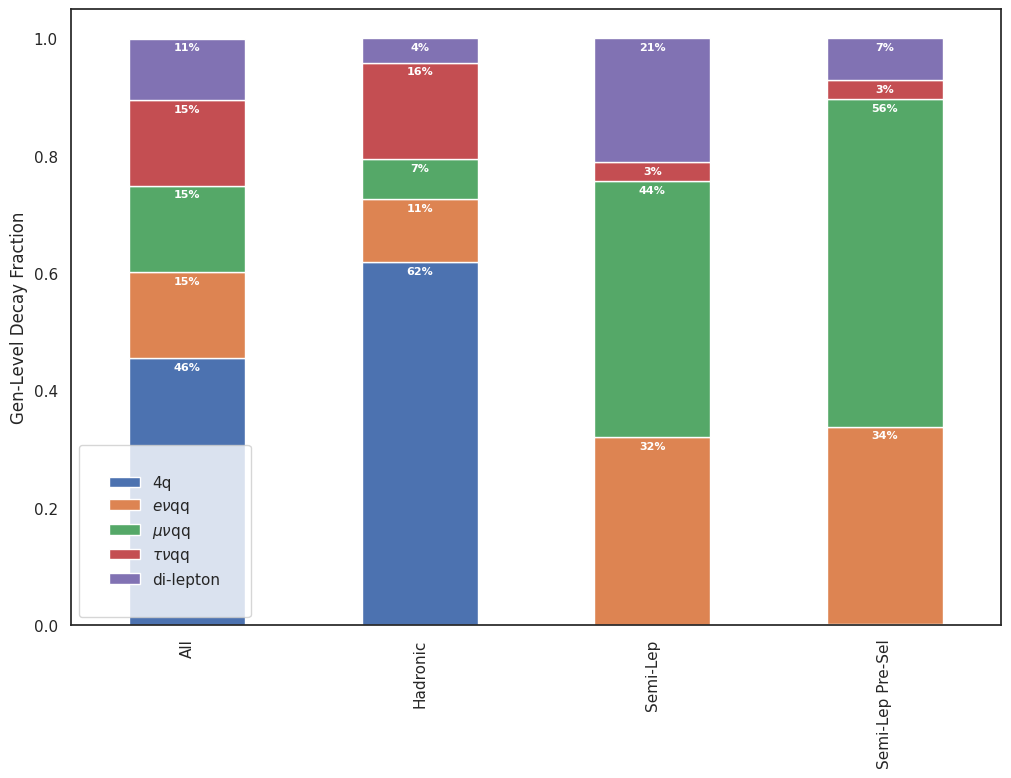

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='white')
fig, ax = plt.subplots(figsize=(12, 8))
plotdata = pd.DataFrame({
    #"Selection": ["All", "Semi-leptonic"],
    "4q": [all_qqqq/all, had_qqqq/had, lep_qqqq/lep, semi_qqqq/semi],
    r"$e\nu$qq" :[all_ele/all, had_ele/had, lep_ele/lep, semi_ele/semi],
    r"$\mu\nu$qq" :[all_mu/all, had_mu/had, lep_mu/lep, semi_mu/semi],
    r"$\tau\nu$qq" :[all_tau/all, had_tau/had, lep_tau/lep, semi_tau/semi],
    "di-lepton": [all_lep/all, 
                  (1-had_qqqq/had-had_ele/had-had_mu/had-had_tau/had),
                  (1-lep_qqqq/lep-lep_ele/lep-lep_mu/lep-lep_tau/lep),
                  (1-semi_qqqq/semi-semi_ele/semi-semi_mu/semi-semi_tau/semi), 
                  ],
    },
    index=["All", "Hadronic", "Semi-Lep", "Semi-Lep Pre-Sel"],
)
plotdata.plot(kind='bar', stacked=True, ax=ax)
y_offset = -0.02

for bar in ax.patches:
  x = ax.text(
      # Put the text in the middle of each bar. get_x returns the start
      # so we add half the width to get to the middle.
      bar.get_x() + bar.get_width() / 2,
      # Vertically, add the height of the bar to the start of the bar,
      # along with the offset.
      bar.get_height() + bar.get_y() + y_offset,
      # This is actual value we'll show.
      f"{round(bar.get_height()*100)}%",
      # Center the labels and style them a bit.
      ha='center',
      color='w',
      weight='bold',
      size=8
  )
ax.set_ylabel("Gen-Level Decay Fraction")
ax.legend(borderpad=2)
#ax.set_ylim(0, 1)
fig.savefig("decayfraction.png")

